# Visualisation for MLP on CMNIST
- vanilla
- DebiAN
- DFA

In [1]:
! pip install pandas

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.7 MB 529 kB/s eta 0:00:01


In [1]:
import os
import captum
import random
import torch
import torchvision
from torchvision import transforms
import numpy as np
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel


from DebiAN.models.simple_cls import MLP

from matplotlib import pyplot as plt
from matplotlib import cm
from PIL import Image
from torchvision import models
from tqdm import tqdm
from os import path
import torch.nn.functional as F
import pandas as pd
from data.utils import get_dataset, IdxDataset
from module.util import get_model

# Functions

In [2]:
from matplotlib import cm
import numpy as np

def overlay(input, cam, alpha=0.9, colormap="jet"):
    # inspired by https://github.com/frgfm/torch-cam/blob/master/torchcam/utils.py

    img = transforms.ToPILImage()(input)
    # normalize to 0,1
    cam -= torch.min(cam)
    cam /= torch.max(cam)
    cam_img = transforms.ToPILImage(mode='F')(cam)

    if type(colormap) is str:
        cmap = cm.get_cmap(colormap)
    else:
        cmap = colormap

    # Resize mask and apply colormap
    overlay_raw = cam_img.resize(img.size, resample=Image.BILINEAR)
    overlay_raw = cam_img.resize(img.size, resample=Image.NEAREST)
    overlay = overlay_raw
    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)
    # Overlay the image with the mask
    overlayed_img = Image.fromarray((alpha * np.asarray(img) + (1 - alpha) * overlay).astype(np.uint8))
    return overlayed_img


def attribute_image_features(net,algorithm, input,label, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=label,
                                              **kwargs
                                             )
    return tensor_attributions





# Parameters

In [3]:
data_path='data'
split='test'
percent='1pct'

models_type=['vanilla','DebiAN','DFA']

Saliency_methods=['integrated_gradient','smoothgrad','deeplift']

# LOAD DB CMNIS

In [4]:
dataset=get_dataset('cmnist',
        data_dir=data_path,
        dataset_split=split,
        transform_split="valid",
        percent=percent)

if dataset.__len__()==0:
    print('Error - data not loaded')
else: 
    print ('{} samples in {} CMNST'.format(dataset.__len__(),split))


10000 samples in test CMNST


# LOAD MODELS

In [5]:
models=dict()
col_names=[]
col_names.append('id')
col_names.append('idx')
col_names.append('gt')
col_names.append('bias')
col_names.append('bias_label')

for m in models_type:
    print(m)
    
     
    if m=='DFA':
        model = get_model('mlp_DISENTANGLE', 10)   
        
        model_path ="ckpt/models_cmnist_LDD/no_dec/{}/best_model_l.th".format(percent)      
        state_dict = torch.load(model_path)
        model.load_state_dict(state_dict['state_dict'])
        model = model.eval()
        models[m+'_l']=model
        
        model_path ="ckpt/models_cmnist_LDD/no_dec/{}/best_model_b.th".format(percent)      
        state_dict = torch.load(model_path)
        model.load_state_dict(state_dict['state_dict'])
        model = model.eval()
        models[m+'_b']=model
        
        print(model)
        
        
    else:
        if m=='vanilla':
            model_path ="ckpt/cmnist/cmnist_{}_{}.th".format(percent,m)  
            model=MLP(last_hidden_layer=32)
            state_dict = torch.load(model_path)
            model.load_state_dict(state_dict['state_dict'])
        if m=='DebiAN':
            model_path ="ckpt/cmnist/cmnist_{}_{}.th".format(percent,m)  
            model=MLP(last_hidden_layer=32)
            state_dict = torch.load(model_path)
            model.load_state_dict(state_dict['model'])  
        if m=='DebiAN100':
            model_path ="ckpt/cmnist/cmnist_{}_mlp100_DebiAN.th".format(percent,m)  
            model=MLP(last_hidden_layer=100)
            state_dict = torch.load(model_path)
            model.load_state_dict(state_dict['model'])   
        model = model.eval()
        print(model)
        models[m]=model
  
    col_names.append('pred_{}'.format(m))
    col_names.append('correct_{}'.format(m))
    col_names.append('prob_{}'.format(m))
    

vanilla
MLP(
  (feature): Sequential(
    (0): Linear(in_features=2352, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=32, bias=True)
    (5): ReLU()
  )
  (classifier): Linear(in_features=32, out_features=10, bias=True)
)
DebiAN
MLP(
  (feature): Sequential(
    (0): Linear(in_features=2352, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=32, bias=True)
    (5): ReLU()
  )
  (classifier): Linear(in_features=32, out_features=10, bias=True)
)
DFA
MLP_DISENTANGLE(
  (feature): Sequential(
    (0): Linear(in_features=2352, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=32, bias=True)
    (5): ReLU()
  )
  (fc): Linear(in_features=

# Prediction

In [6]:
df=pd.DataFrame(columns=col_names) 
for idx_img in tqdm(range(len(dataset))):
    new_row = dict.fromkeys(col_names, 0)   
    image,label,idx = dataset[idx_img]
    l_target,l_bias=label
    l_target=l_target.item()
    l_bias=l_bias.item()
    x=torch.unsqueeze(image, 0)
    new_row['id']=idx_img
    new_row['idx']=idx
    new_row['gt']=l_target
    new_row['bias_label']=l_bias
    bias=0
    if l_bias==l_target:
        bias=1      
    new_row['bias']=bias 
    for m in models_type:
        if m=='DFA':
            l1=models[m+'_l'].extract(x)  
            l2=models[m+'_b'].extract(x)  
            logits=models[m+'_l'].fc(torch.hstack((l1,l2)))
            
            #indices = np.random.permutation(l2.size(0))
            #l2_swap = l2[indices]  # z tilde
            #z = torch.cat((l1, l2_swap), dim=1)
            #logits=models[m+'_l'].fc(z)
            
            
        else:
            logits=models[m](x)
        assert logits.shape[1]==10
        pred = logits.data.max(1, keepdim=True)[1].squeeze(1)  
        new_row['pred_{}'.format(m)]=pred.item()
        new_row['prob_{}'.format(m)]= torch.max(F.softmax(logits, 1)).item()
        correct=0
        if pred==l_target:
            correct=1
        new_row['correct_{}'.format(m)]=correct
        new_df = pd.DataFrame([new_row], columns=col_names)
    df = pd.concat([new_df, df], ignore_index = True)
       

100%|██████████| 10000/10000 [00:34<00:00, 293.58it/s]


# Accuracy

<AxesSubplot:>

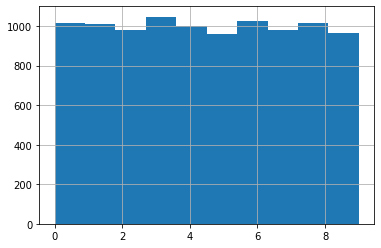

In [7]:
df['bias_label'].hist()

In [8]:
conflict_df=df[df.bias==0]
align_df=df[df.bias==1]
ratio=len(conflict_df)/len(df)
print('RATIO: {}'.format(ratio))

# Accuracy
acc_vanilla=df['correct_vanilla'].sum()/len(df)
acc_DebiAN=df['correct_DebiAN'].sum()/len(df)
acc_DebiAN100=df['correct_DFA'].sum()/len(df)
print(acc_vanilla)
print(acc_DebiAN)
print(acc_DebiAN100)



# Accuracy align-bias data
align_acc_vanilla=align_df['correct_vanilla'].sum()/len(align_df)
align_acc_DebiAN=align_df['correct_DebiAN'].sum()/len(align_df)
align_acc_DebiAN100=align_df['correct_DFA'].sum()/len(align_df)
print(align_acc_vanilla)
print(align_acc_DebiAN)
print(align_acc_DebiAN100)

# Accuracy conflict-bias data
conflict_acc_vanilla=conflict_df['correct_vanilla'].sum()/len(conflict_df)
conflict_acc_DebiAN=conflict_df['correct_DebiAN'].sum()/len(conflict_df)
conflict_acc_DebiAN100=conflict_df['correct_DFA'].sum()/len(conflict_df)
print(conflict_acc_vanilla)
print(conflict_acc_DebiAN)
print(conflict_acc_DebiAN100)

RATIO: 0.8994
0.4619
0.4292
0.1058
0.9950298210735586
0.9960238568588469
0.9264413518886679
0.40226817878585724
0.3657994218367801
0.014009339559706471


# Visualize prediction Biased

In [91]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [79]:
df_b=df[(df.correct_vanilla==0)&(df.correct_DFA==1)]

In [82]:
print(len(df_b))
print(df_b)

17
        id gt bias bias_label pred_vanilla correct_vanilla  prob_vanilla  \
482   4517  5    1          5            1               0      0.669997   
521   4478  4    1          4            0               0      0.993117   
652   4347  5    1          5            4               0      0.999953   
888   4111  5    1          5            6               0      0.795221   
969   4030  3    0          2            2               0      1.000000   
1265  3734  0    0          8            8               0      0.999933   
1659  3340  5    1          5            1               0      0.933214   
2067  2932  9    1          9            7               0      0.610049   
2149  2850  1    1          1            2               0      0.988855   
2636  2363  1    1          1            6               0      0.950430   
3046  1953  1    1          1            2               0      1.000000   
3223  1776  5    1          5            6               0      0.783947   
3568  143

In [87]:
image_idx=4478
image,label,idx = dataset[image_idx]
x=torch.unsqueeze(image, 0)
image=torch.squeeze(image,0)
x.requires_grad = True
model=models['DebiAN']

In [89]:
# Integrated Gradient
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(model,ig, x,l_target, baselines=x * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

# Integrated Gradient with Smoothgrad
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(model,nt,x,l_target, baselines=x * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
#DeepLift
dl = DeepLift(model)
attr_dl = attribute_image_features(model,dl, x,l_target,baselines=x * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

Approximation delta:  tensor([0.1755], dtype=torch.float64)


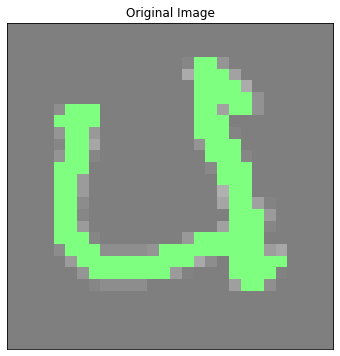

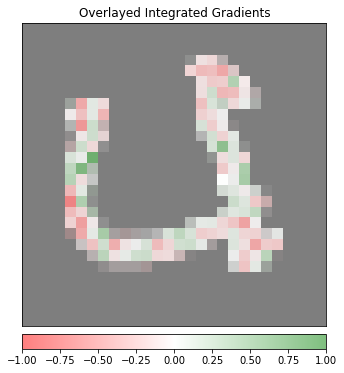

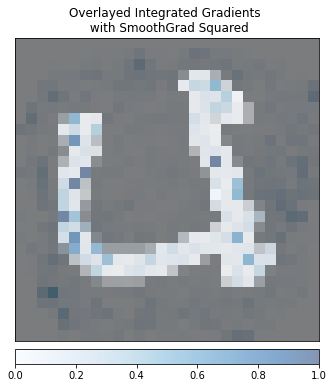

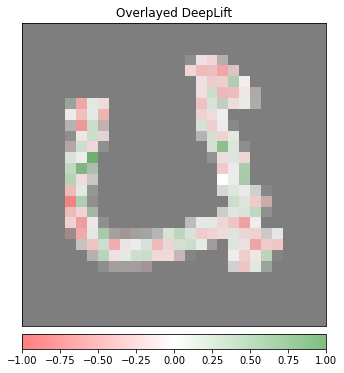

In [92]:
original_image = np.transpose((image.cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")

In [ ]:
attr_ig.shape